In [53]:
# 필요한 함수, 모듈 업로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
from sklearn.preprocessing import StandardScaler
import copy
pd.set_option('display.max_rows', 100)

import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [54]:
df1 = pd.read_csv('./독립변수/final_elec.csv')
df2 = pd.read_csv('./독립변수/final_gas.csv', encoding = 'cp949')
df3 = pd.read_csv('./독립변수/final_kau.csv')

In [55]:
df1

,Date,설비용량(MW),공급능력(MW),최대전력(MW),공급예비력(MW),공급예비율(%)
0,2017-01-01,105866,89861,59234,30627,51.7
1,2017-01-02,105866,92573,72901,19672,27.0
2,2017-01-03,105866,94223,75471,18752,24.8
3,2017-01-04,105866,92353,75778,16575,21.9
4,2017-01-05,105866,92474,76304,16170,21.2
...,...,...,...,...,...,...
2805,2024-08-19,149179,104640,95611,9029,9.4
2806,2024-08-20,149179,105360,97115,8245,8.5
2807,2024-08-21,149185,105236,92623,12613,13.6
2808,2024-08-22,149185,104705,93224,11481,12.3


In [56]:
df2

,date,gas
0,2014-07-28,3.765
1,2014-07-29,3.824
2,2014-07-30,3.786
3,2014-07-31,3.841
4,2014-08-01,3.798
...,...,...
2475,2024-08-19,2.235
2476,2024-08-20,2.198
2477,2024-08-21,2.177
2478,2024-08-22,2.053


In [57]:
df2.rename(columns = {'date' : 'Date'}, inplace = True)

In [58]:
df1.columns

Index(['Date', '설비용량(MW)', '공급능력(MW)', '최대전력(MW)', '공급예비력(MW)', '공급예비율(%)'], dtype='object')

In [59]:
combined = pd.merge(df1[['Date', '최대전력(MW)', '공급예비력(MW)', '공급예비율(%)']], df2, on = 'Date', how = 'inner')
combined

,Date,최대전력(MW),공급예비력(MW),공급예비율(%),gas
0,2017-01-02,72901,19672,27.0,NaN
1,2017-01-03,75471,18752,24.8,3.327
2,2017-01-04,75778,16575,21.9,3.267
3,2017-01-05,76304,16170,21.2,3.273
4,2017-01-06,74060,18781,25.4,3.285
...,...,...,...,...,...
1887,2024-08-19,95611,9029,9.4,2.235
1888,2024-08-20,97115,8245,8.5,2.198
1889,2024-08-21,92623,12613,13.6,2.177
1890,2024-08-22,93224,11481,12.3,2.053


In [60]:
df3.rename(columns = {'date': 'Date'}, inplace = True)

In [61]:
total_df = pd.merge(combined, df3[['Date', '종가', '거래량']], on = 'Date', how = 'inner')
total_df

,Date,최대전력(MW),공급예비력(MW),공급예비율(%),gas,종가,거래량
0,2019-07-01,73799,18018,24.4,2.267,"28,150","2,000"
1,2019-07-02,73871,18356,24.8,2.240,"28,150","1,500"
2,2019-07-03,74051,18661,25.2,2.290,"28,100","6,000"
3,2019-07-04,75978,17968,23.6,NaN,"28,150","1,500"
4,2019-07-05,77081,17310,22.5,2.418,"28,150","5,000"
...,...,...,...,...,...,...,...
1277,2024-08-19,95611,9029,9.4,2.235,"9,130","160,576"
1278,2024-08-20,97115,8245,8.5,2.198,"9,100","84,491"
1279,2024-08-21,92623,12613,13.6,2.177,"9,200","264,105"
1280,2024-08-22,93224,11481,12.3,2.053,"9,290","104,771"


In [62]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1282 entries, 0 to 1281
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1282 non-null   object 
 1   최대전력(MW)   1282 non-null   int64  
 2   공급예비력(MW)  1282 non-null   int64  
 3   공급예비율(%)   1282 non-null   float64
 4   gas        1240 non-null   float64
 5   종가         1282 non-null   object 
 6   거래량        1282 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 70.2+ KB


In [63]:
total_df['종가'] = total_df['종가'].str.replace(',', '').astype(float)
total_df['거래량'] = total_df['거래량'].str.replace(',', '').astype(float)

In [64]:
total_df.isnull().sum()

Date          0
최대전력(MW)      0
공급예비력(MW)     0
공급예비율(%)      0
gas          42
종가            0
거래량           0
dtype: int64

In [65]:

total_df['gas'].fillna(method = 'bfill', inplace = True)
total_df.isnull().sum()

/var/folders/f9/6q54pn6j5cb3sqhqbmxdvs1c0000gn/T/ipykernel_16907/2156490948.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  total_df['gas'].fillna(method = 'bfill', inplace = True)
/var/folders/f9/6q54pn6j5cb3sqhqbmxdvs1c0000gn/T/ipykernel_16907/2156490948.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  total_df['gas'].fillna(method = 'bfill', inplace = True)


Date         0
최대전력(MW)     0
공급예비력(MW)    0
공급예비율(%)     0
gas          0
종가           0
거래량          0
dtype: int64

In [66]:
total_df['diff_close'] = total_df['종가'].pct_change(1)

In [67]:
total_df

,Date,최대전력(MW),공급예비력(MW),공급예비율(%),gas,종가,거래량,diff_close
0,2019-07-01,73799,18018,24.4,2.267,28150.0,2000.0,NaN
1,2019-07-02,73871,18356,24.8,2.240,28150.0,1500.0,0.000000
2,2019-07-03,74051,18661,25.2,2.290,28100.0,6000.0,-0.001776
3,2019-07-04,75978,17968,23.6,2.418,28150.0,1500.0,0.001779
4,2019-07-05,77081,17310,22.5,2.418,28150.0,5000.0,0.000000
...,...,...,...,...,...,...,...,...
1277,2024-08-19,95611,9029,9.4,2.235,9130.0,160576.0,-0.007609
1278,2024-08-20,97115,8245,8.5,2.198,9100.0,84491.0,-0.003286
1279,2024-08-21,92623,12613,13.6,2.177,9200.0,264105.0,0.010989
1280,2024-08-22,93224,11481,12.3,2.053,9290.0,104771.0,0.009783


In [68]:
total_df = total_df.dropna()

In [69]:
total_df.columns

Index(['Date', '최대전력(MW)', '공급예비력(MW)', '공급예비율(%)', 'gas', '종가', '거래량',
       'diff_close'],
      dtype='object')

In [70]:
total_df = total_df[['최대전력(MW)', '공급예비력(MW)', '공급예비율(%)', 'gas', '종가', '거래량',
       'diff_close']]

In [71]:
data, dataname = total_df, 'total_df' # stock_df / total_df
TARGET = "diff_close"                      # "diff_close"
SEQ_SIZE = 60                        # 30 / 60
PRED_SIZE = 20
BATCH_SIZE = 4                    #  4 / 8
HIDDEN_SIZE = 128                # 64 / 128
EPOCHS = 1000

In [72]:
def split_xy(dataset, time_steps, y_column):
    x, y = list(), list()
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column

        if y_end_number > len(dataset):
            break
        tmp_x = dataset.iloc[i:x_end_number, :]  # Adjusted for Pandas
        tmp_y = dataset.iloc[x_end_number:y_end_number, :].loc[:, TARGET]
        x.append(tmp_x.values)  # Convert to numpy array
        y.append(tmp_y.values)  # Convert to numpy array

    return np.array(x), np.array(y)

X, y = split_xy(data, SEQ_SIZE, PRED_SIZE)
print(X[0,:],"\n", y[0])
print("X size : ", X.shape)
print("y size : ", y.shape)

[[ 7.38710000e+04  1.83560000e+04  2.48000000e+01  2.24000000e+00
   2.81500000e+04  1.50000000e+03  0.00000000e+00]
 [ 7.40510000e+04  1.86610000e+04  2.52000000e+01  2.29000000e+00
   2.81000000e+04  6.00000000e+03 -1.77619893e-03]
 [ 7.59780000e+04  1.79680000e+04  2.36000000e+01  2.41800000e+00
   2.81500000e+04  1.50000000e+03  1.77935943e-03]
 [ 7.70810000e+04  1.73100000e+04  2.25000000e+01  2.41800000e+00
   2.81500000e+04  5.00000000e+03  0.00000000e+00]
 [ 7.45110000e+04  1.99230000e+04  2.67000000e+01  2.40300000e+00
   2.82000000e+04  3.00000000e+03  1.77619893e-03]
 [ 7.48470000e+04  1.94320000e+04  2.60000000e+01  2.42500000e+00
   2.82000000e+04  1.50000000e+03  0.00000000e+00]
 [ 7.35820000e+04  2.24170000e+04  3.05000000e+01  2.44400000e+00
   2.82000000e+04  2.00000000e+03  0.00000000e+00]
 [ 7.37620000e+04  2.16190000e+04  2.93000000e+01  2.41600000e+00
   2.82000000e+04  3.00000000e+03  0.00000000e+00]
 [ 7.37200000e+04  2.05020000e+04  2.78000000e+01  2.45300000e+0

In [73]:
X_test = data.tail(SEQ_SIZE).values.reshape(1, SEQ_SIZE, data.shape[1])
print(X_test)
print("X_test size : ", X_test.shape)

[[[ 6.75580000e+04  1.38720000e+04  2.05000000e+01  2.91800000e+00
    8.64000000e+03  1.07410000e+05  4.65116279e-03]
  [ 7.21340000e+04  1.10200000e+04  1.53000000e+01  2.90600000e+00
    8.65000000e+03  3.65841000e+05  1.15740741e-03]
  [ 7.42440000e+04  1.13530000e+04  1.53000000e+01  3.12900000e+00
    8.68000000e+03  3.68411000e+05  3.46820809e-03]
  [ 7.42510000e+04  1.00960000e+04  1.36000000e+01  3.04500000e+00
    8.67000000e+03  2.85464000e+05 -1.15207373e-03]
  [ 7.61440000e+04  9.32600000e+03  1.22000000e+01  2.95900000e+00
    8.71000000e+03  3.57368000e+05  4.61361015e-03]
  [ 7.56190000e+04  1.12820000e+04  1.49000000e+01  2.88100000e+00
    8.76000000e+03  3.20547000e+05  5.74052813e-03]
  [ 7.39580000e+04  1.28700000e+04  1.74000000e+01  2.78800000e+00
    8.82000000e+03  4.22249000e+05  6.84931507e-03]
  [ 7.68260000e+04  1.06210000e+04  1.38000000e+01  2.90900000e+00
    8.85000000e+03  3.89198000e+05  3.40136054e-03]
  [ 8.00770000e+04  9.09300000e+03  1.14000000e+

In [74]:
from sklearn.preprocessing import StandardScaler

X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X = X.reshape(X.shape[0], SEQ_SIZE, data.shape[1])

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
X_test = scaler.transform(X_test)
X_test = X_test.reshape(X_test.shape[0], SEQ_SIZE, data.shape[1])

print("X size : ", X.shape)
print("X_test size : ", X_test.shape)

X size :  (1202, 60, 7)
X_test size :  (1, 60, 7)


In [75]:
# to DataLoader
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 1, test_size = 0.2)

# to tensor
X_train = torch.tensor(X_train.astype(np.float32), dtype = torch.float32)
X_valid = torch.tensor(X_valid.astype(np.float32), dtype = torch.float32)
y_train = torch.tensor(y_train.astype(np.float32), dtype = torch.float32)
y_valid = torch.tensor(y_valid.astype(np.float32), dtype = torch.float32)

# to DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size = BATCH_SIZE, shuffle = False)

In [76]:
class InformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, window_size, forecast_horizon, num_layers=3, hidden_size=128, num_heads=8, dropout=0.1):
        super(InformerModel, self).__init__()
        self.window_size = window_size
        self.forecast_horizon = forecast_horizon
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_size = hidden_size
        self.num_heads = num_heads

        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        self.d_k = hidden_size // num_heads

        # Input embedding and positional encoding
        self.input_embedding = nn.Linear(input_dim, hidden_size)
        self.pos_encoding = PositionalEncoding(hidden_size)

        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(hidden_size, num_heads, dropout) for _ in range(num_layers)
        ])

        # Decoder layers
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(hidden_size, num_heads, dropout) for _ in range(num_layers)
        ])

        # Output layer
        self.output_linear = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        # x shape: (batch_size, window_size, input_dim)
        x = self.input_embedding(x)  # (batch_size, window_size, hidden_size)
        x = self.pos_encoding(x)
        
        # Reshape for multi-head attention (requires seq_len first in dim)
        x = x.permute(1, 0, 2)  # (window_size, batch_size, hidden_size)

        # Encoder processing
        for layer in self.encoder_layers:
            x = layer(x)  # (window_size, batch_size, hidden_size)

        # Decoder processing: Initialize decoder input with encoded output
        decoder_input = x[-1:, :, :]  # (1, batch_size, hidden_size)
        outputs = []
        for _ in range(self.forecast_horizon):
            y = self.pos_encoding(decoder_input.permute(1, 0, 2))  # (batch_size, 1, hidden_size)
            y = y.permute(1, 0, 2)  # (1, batch_size, hidden_size)
            for layer in self.decoder_layers:
                y = layer(y, x)
            output = self.output_linear(y.permute(1, 0, 2))  # (batch_size, 1, output_dim)
            outputs.append(output)
            
            # Use the current output as the next decoder input
            decoder_input = output.permute(1, 0, 2)  # (1, batch_size, output_dim)

        outputs = torch.cat(outputs, dim=1)  # (batch_size, forecast_horizon, output_dim)
        return outputs
    
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
    
class EncoderLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(hidden_size, num_heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ReLU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )
        self.layernorm1 = nn.LayerNorm(hidden_size)
        self.layernorm2 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.self_attention(x, x, x)
        x = x + self.dropout(attn_output)
        x = self.layernorm1(x)

        ff_output = self.feed_forward(x)
        x = x + self.dropout(ff_output)
        x = self.layernorm2(x)

        return x


class DecoderLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(hidden_size, num_heads, dropout=dropout)
        self.cross_attention = nn.MultiheadAttention(hidden_size, num_heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ReLU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )
        self.layernorm1 = nn.LayerNorm(hidden_size)
        self.layernorm2 = nn.LayerNorm(hidden_size)
        self.layernorm3 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output):
        attn_output, _ = self.self_attention(x, x, x)
        x = x + self.dropout(attn_output)
        x = self.layernorm1(x)

        cross_output, _ = self.cross_attention(x, enc_output, enc_output)
        x = x + self.dropout(cross_output)
        x = self.layernorm2(x)

        ff_output = self.feed_forward(x)
        x = x + self.dropout(ff_output)
        x = self.layernorm3(x)

        return x
    

class ProbSparseAttention(nn.Module):
    def __init__(self, scale, d_k, n_heads, mask_flag=True, dropout=0.1):
        super(ProbSparseAttention, self).__init__()
        self.scale = scale
        self.d_k = d_k
        self.n_heads = n_heads
        self.mask_flag = mask_flag
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, attn_mask):
        B, L_Q, D = queries.shape
        _, L_K, _ = keys.shape

        queries = queries.view(B, L_Q, self.n_heads, D // self.n_heads)
        keys = keys.view(B, L_K, self.n_heads, D // self.n_heads)
        values = values.view(B, L_K, self.n_heads, D // self.n_heads)

        U_part = self.scale * torch.einsum('blhd,bsmd->bhsld', queries, keys)

        if self.mask_flag:
            mask = torch.tril(torch.ones(L_Q, L_K)).unsqueeze(0).unsqueeze(0).to(queries.device)
            attn_mask = mask if attn_mask is None else attn_mask & mask
            U_part.masked_fill_(attn_mask == 0, float('-inf'))

        attn = torch.softmax(U_part, dim=-1)
        attn = self.dropout(attn)

        output = torch.einsum('bhsld,bshd->blhd', attn, values).contiguous()
        output = output.view(B, L_Q, D)

        return output, attn

In [77]:
class EarlyStopping:
    def __init__(self, patience = 5, min_delta = 0, restore_best_weights = True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False
    
    
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

Training with window_size=60, hidden_size=64, num_heads=4
Epoch 1/200, Train Loss: 0.0766, Validation Loss: 0.0448, Best Loss: 0.0448
Epoch 2/200, Train Loss: 0.0371, Validation Loss: 0.0347, Best Loss: 0.0347
Epoch 3/200, Train Loss: 0.0358, Validation Loss: 0.0333, Best Loss: 0.0333
Epoch 4/200, Train Loss: 0.0350, Validation Loss: 0.0354, Best Loss: 0.0333
Epoch 5/200, Train Loss: 0.0351, Validation Loss: 0.0349, Best Loss: 0.0333
Epoch 6/200, Train Loss: 0.0342, Validation Loss: 0.0398, Best Loss: 0.0333
Epoch 7/200, Train Loss: 0.0340, Validation Loss: 0.0334, Best Loss: 0.0333
Epoch 8/200, Train Loss: 0.0350, Validation Loss: 0.0338, Best Loss: 0.0333
Epoch 9/200, Train Loss: 0.0338, Validation Loss: 0.0330, Best Loss: 0.0330
Epoch 10/200, Train Loss: 0.0343, Validation Loss: 0.0331, Best Loss: 0.0330
Epoch 11/200, Train Loss: 0.0334, Validation Loss: 0.0330, Best Loss: 0.0330
Epoch 12/200, Train Loss: 0.0337, Validation Loss: 0.0331, Best Loss: 0.0330
Epoch 13/200, Train Loss: 0

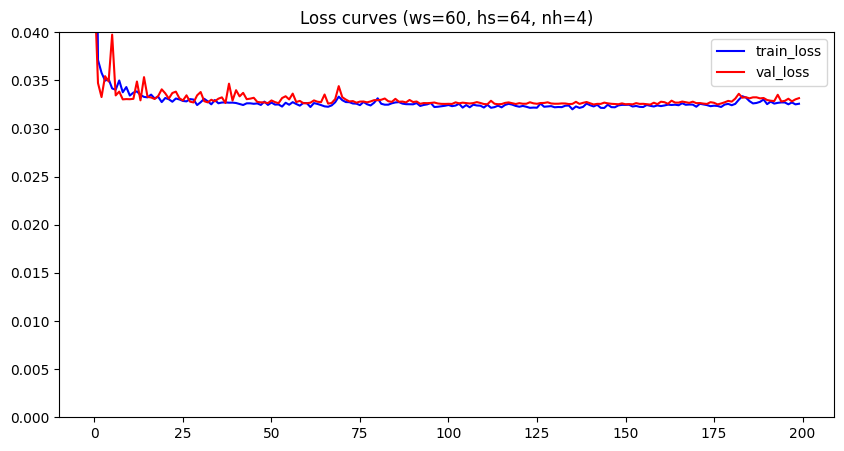

Training with window_size=60, hidden_size=64, num_heads=8
Epoch 1/200, Train Loss: 0.0697, Validation Loss: 0.0511, Best Loss: 0.0511
Epoch 2/200, Train Loss: 0.0373, Validation Loss: 0.0334, Best Loss: 0.0334
Epoch 3/200, Train Loss: 0.0350, Validation Loss: 0.0333, Best Loss: 0.0333
Epoch 4/200, Train Loss: 0.0344, Validation Loss: 0.0349, Best Loss: 0.0333
Epoch 5/200, Train Loss: 0.0343, Validation Loss: 0.0332, Best Loss: 0.0332
Epoch 6/200, Train Loss: 0.0346, Validation Loss: 0.0339, Best Loss: 0.0332
Epoch 7/200, Train Loss: 0.0343, Validation Loss: 0.0331, Best Loss: 0.0331
Epoch 8/200, Train Loss: 0.0342, Validation Loss: 0.0346, Best Loss: 0.0331
Epoch 9/200, Train Loss: 0.0341, Validation Loss: 0.0339, Best Loss: 0.0331
Epoch 10/200, Train Loss: 0.0335, Validation Loss: 0.0333, Best Loss: 0.0331
Epoch 11/200, Train Loss: 0.0336, Validation Loss: 0.0331, Best Loss: 0.0331
Epoch 12/200, Train Loss: 0.0332, Validation Loss: 0.0330, Best Loss: 0.0330
Epoch 13/200, Train Loss: 0

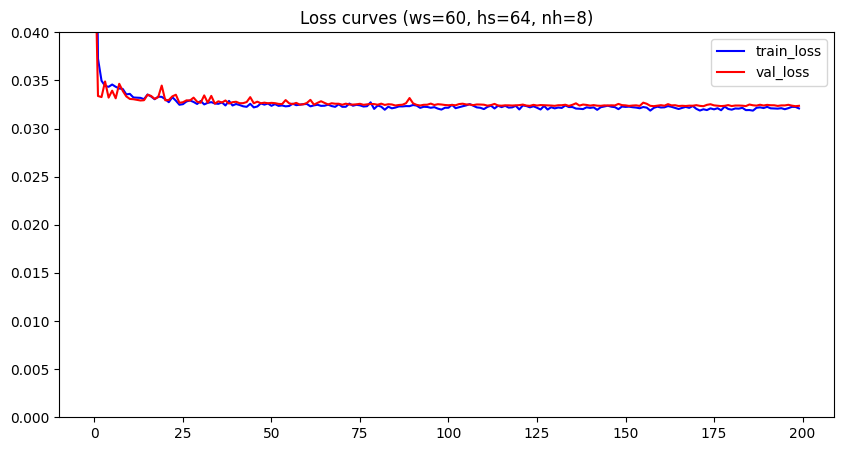

Training with window_size=60, hidden_size=128, num_heads=4
Epoch 1/200, Train Loss: 0.0820, Validation Loss: 0.0362, Best Loss: 0.0362
Epoch 2/200, Train Loss: 0.0374, Validation Loss: 0.0341, Best Loss: 0.0341
Epoch 3/200, Train Loss: 0.0361, Validation Loss: 0.0346, Best Loss: 0.0341
Epoch 4/200, Train Loss: 0.0353, Validation Loss: 0.0409, Best Loss: 0.0341
Epoch 5/200, Train Loss: 0.0349, Validation Loss: 0.0499, Best Loss: 0.0341
Epoch 6/200, Train Loss: 0.0346, Validation Loss: 0.0331, Best Loss: 0.0331
Epoch 7/200, Train Loss: 0.0340, Validation Loss: 0.0330, Best Loss: 0.0330
Epoch 8/200, Train Loss: 0.0339, Validation Loss: 0.0332, Best Loss: 0.0330
Epoch 9/200, Train Loss: 0.0336, Validation Loss: 0.0356, Best Loss: 0.0330
Epoch 10/200, Train Loss: 0.0337, Validation Loss: 0.0330, Best Loss: 0.0330
Epoch 11/200, Train Loss: 0.0335, Validation Loss: 0.0333, Best Loss: 0.0330
Epoch 12/200, Train Loss: 0.0334, Validation Loss: 0.0339, Best Loss: 0.0330
Epoch 13/200, Train Loss: 

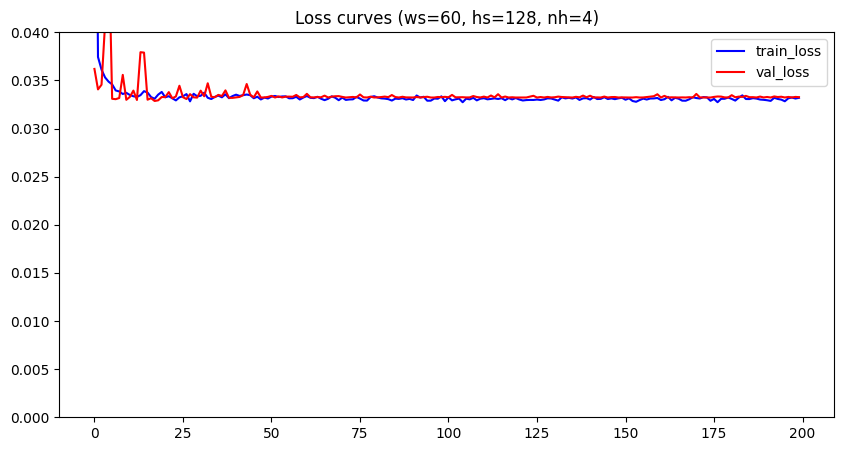

Training with window_size=60, hidden_size=128, num_heads=8
Epoch 1/200, Train Loss: 0.1000, Validation Loss: 0.0660, Best Loss: 0.0660
Epoch 2/200, Train Loss: 0.0375, Validation Loss: 0.0363, Best Loss: 0.0363
Epoch 3/200, Train Loss: 0.0353, Validation Loss: 0.0334, Best Loss: 0.0334
Epoch 4/200, Train Loss: 0.0359, Validation Loss: 0.0383, Best Loss: 0.0334
Epoch 5/200, Train Loss: 0.0350, Validation Loss: 0.0331, Best Loss: 0.0331
Epoch 6/200, Train Loss: 0.0341, Validation Loss: 0.0398, Best Loss: 0.0331
Epoch 7/200, Train Loss: 0.0341, Validation Loss: 0.0373, Best Loss: 0.0331
Epoch 8/200, Train Loss: 0.0351, Validation Loss: 0.0330, Best Loss: 0.0330
Epoch 9/200, Train Loss: 0.0337, Validation Loss: 0.0370, Best Loss: 0.0330
Epoch 10/200, Train Loss: 0.0349, Validation Loss: 0.0332, Best Loss: 0.0330
Epoch 11/200, Train Loss: 0.0333, Validation Loss: 0.0332, Best Loss: 0.0330
Epoch 12/200, Train Loss: 0.0339, Validation Loss: 0.0335, Best Loss: 0.0330
Epoch 13/200, Train Loss: 

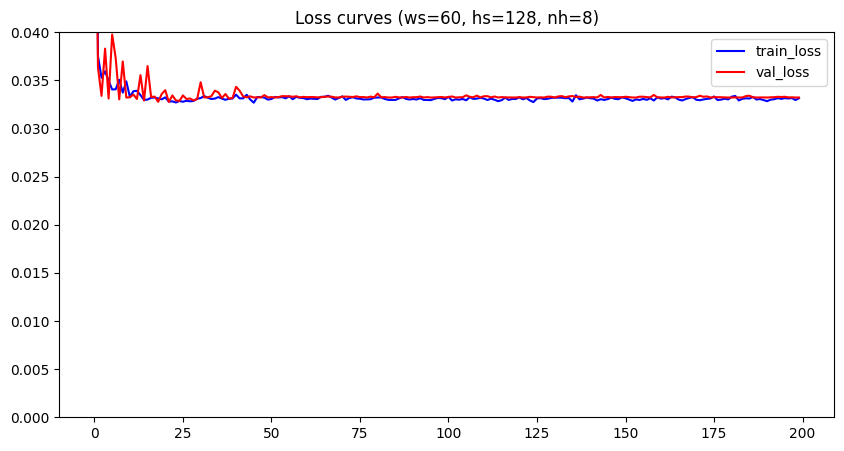

Training with window_size=120, hidden_size=64, num_heads=4
Epoch 1/200, Train Loss: 0.0794, Validation Loss: 0.0404, Best Loss: 0.0404
Epoch 2/200, Train Loss: 0.0370, Validation Loss: 0.0371, Best Loss: 0.0371
Epoch 3/200, Train Loss: 0.0352, Validation Loss: 0.0331, Best Loss: 0.0331
Epoch 4/200, Train Loss: 0.0344, Validation Loss: 0.0332, Best Loss: 0.0331
Epoch 5/200, Train Loss: 0.0344, Validation Loss: 0.0338, Best Loss: 0.0331
Epoch 6/200, Train Loss: 0.0338, Validation Loss: 0.0342, Best Loss: 0.0331
Epoch 7/200, Train Loss: 0.0339, Validation Loss: 0.0389, Best Loss: 0.0331
Epoch 8/200, Train Loss: 0.0352, Validation Loss: 0.0333, Best Loss: 0.0331
Epoch 9/200, Train Loss: 0.0333, Validation Loss: 0.0356, Best Loss: 0.0331
Epoch 10/200, Train Loss: 0.0334, Validation Loss: 0.0344, Best Loss: 0.0331
Epoch 11/200, Train Loss: 0.0337, Validation Loss: 0.0332, Best Loss: 0.0331
Epoch 12/200, Train Loss: 0.0332, Validation Loss: 0.0331, Best Loss: 0.0331
Epoch 13/200, Train Loss: 

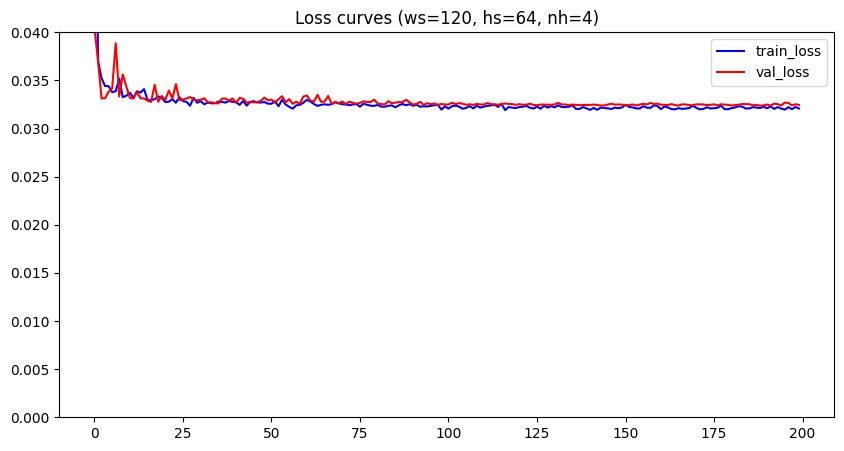

Training with window_size=120, hidden_size=64, num_heads=8
Epoch 1/200, Train Loss: 0.0680, Validation Loss: 0.0334, Best Loss: 0.0334
Epoch 2/200, Train Loss: 0.0357, Validation Loss: 0.0386, Best Loss: 0.0334
Epoch 3/200, Train Loss: 0.0352, Validation Loss: 0.0333, Best Loss: 0.0333
Epoch 4/200, Train Loss: 0.0343, Validation Loss: 0.0336, Best Loss: 0.0333
Epoch 5/200, Train Loss: 0.0339, Validation Loss: 0.0345, Best Loss: 0.0333
Epoch 6/200, Train Loss: 0.0345, Validation Loss: 0.0331, Best Loss: 0.0331
Epoch 7/200, Train Loss: 0.0338, Validation Loss: 0.0334, Best Loss: 0.0331
Epoch 8/200, Train Loss: 0.0345, Validation Loss: 0.0330, Best Loss: 0.0330
Epoch 9/200, Train Loss: 0.0340, Validation Loss: 0.0339, Best Loss: 0.0330
Epoch 10/200, Train Loss: 0.0336, Validation Loss: 0.0339, Best Loss: 0.0330
Epoch 11/200, Train Loss: 0.0334, Validation Loss: 0.0338, Best Loss: 0.0330
Epoch 12/200, Train Loss: 0.0333, Validation Loss: 0.0330, Best Loss: 0.0330
Epoch 13/200, Train Loss: 

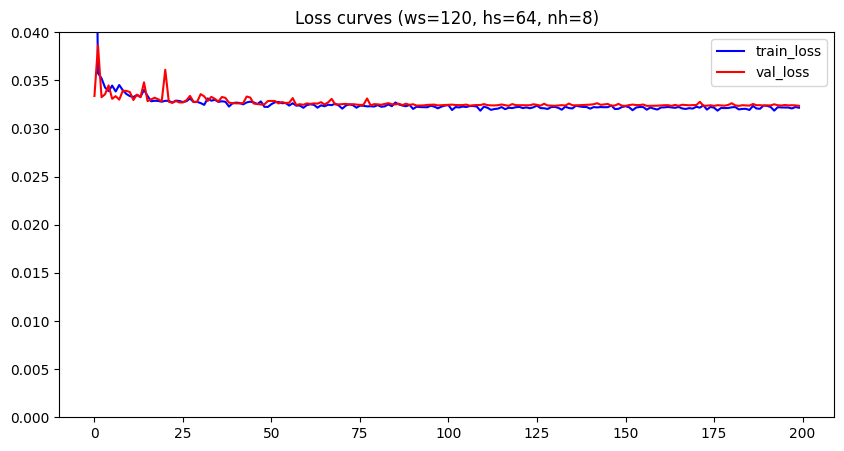

Training with window_size=120, hidden_size=128, num_heads=4
Epoch 1/200, Train Loss: 0.0872, Validation Loss: 0.0354, Best Loss: 0.0354
Epoch 2/200, Train Loss: 0.0393, Validation Loss: 0.0431, Best Loss: 0.0354
Epoch 3/200, Train Loss: 0.0357, Validation Loss: 0.0333, Best Loss: 0.0333
Epoch 4/200, Train Loss: 0.0348, Validation Loss: 0.0340, Best Loss: 0.0333
Epoch 5/200, Train Loss: 0.0346, Validation Loss: 0.0348, Best Loss: 0.0333
Epoch 6/200, Train Loss: 0.0343, Validation Loss: 0.0343, Best Loss: 0.0333
Epoch 7/200, Train Loss: 0.0346, Validation Loss: 0.0341, Best Loss: 0.0333
Epoch 8/200, Train Loss: 0.0340, Validation Loss: 0.0331, Best Loss: 0.0331
Epoch 9/200, Train Loss: 0.0342, Validation Loss: 0.0331, Best Loss: 0.0331
Epoch 10/200, Train Loss: 0.0340, Validation Loss: 0.0334, Best Loss: 0.0331
Epoch 11/200, Train Loss: 0.0337, Validation Loss: 0.0338, Best Loss: 0.0331
Epoch 12/200, Train Loss: 0.0339, Validation Loss: 0.0331, Best Loss: 0.0331
Epoch 13/200, Train Loss:

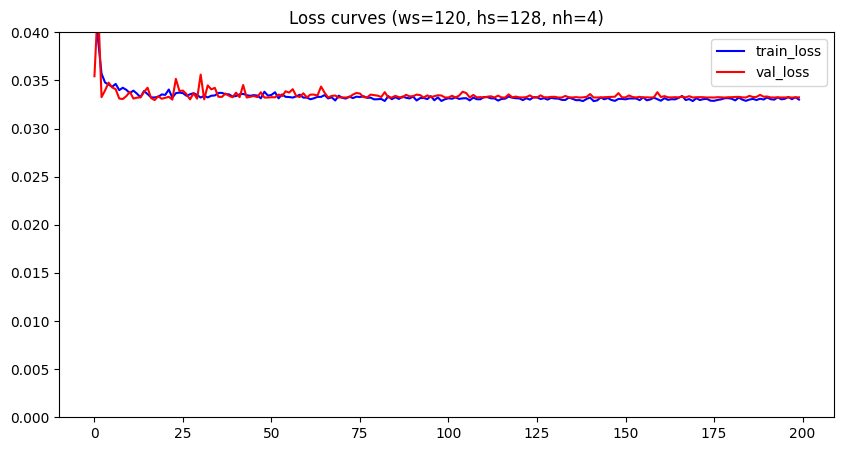

Training with window_size=120, hidden_size=128, num_heads=8
Epoch 1/200, Train Loss: 0.0964, Validation Loss: 0.0487, Best Loss: 0.0487
Epoch 2/200, Train Loss: 0.0370, Validation Loss: 0.0375, Best Loss: 0.0375
Epoch 3/200, Train Loss: 0.0372, Validation Loss: 0.0445, Best Loss: 0.0375
Epoch 4/200, Train Loss: 0.0359, Validation Loss: 0.0355, Best Loss: 0.0355
Epoch 5/200, Train Loss: 0.0360, Validation Loss: 0.0339, Best Loss: 0.0339
Epoch 6/200, Train Loss: 0.0340, Validation Loss: 0.0376, Best Loss: 0.0339
Epoch 7/200, Train Loss: 0.0340, Validation Loss: 0.0331, Best Loss: 0.0331
Epoch 8/200, Train Loss: 0.0343, Validation Loss: 0.0359, Best Loss: 0.0331
Epoch 9/200, Train Loss: 0.0342, Validation Loss: 0.0355, Best Loss: 0.0331
Epoch 10/200, Train Loss: 0.0336, Validation Loss: 0.0345, Best Loss: 0.0331
Epoch 11/200, Train Loss: 0.0337, Validation Loss: 0.0376, Best Loss: 0.0331
Epoch 12/200, Train Loss: 0.0338, Validation Loss: 0.0330, Best Loss: 0.0330
Epoch 13/200, Train Loss:

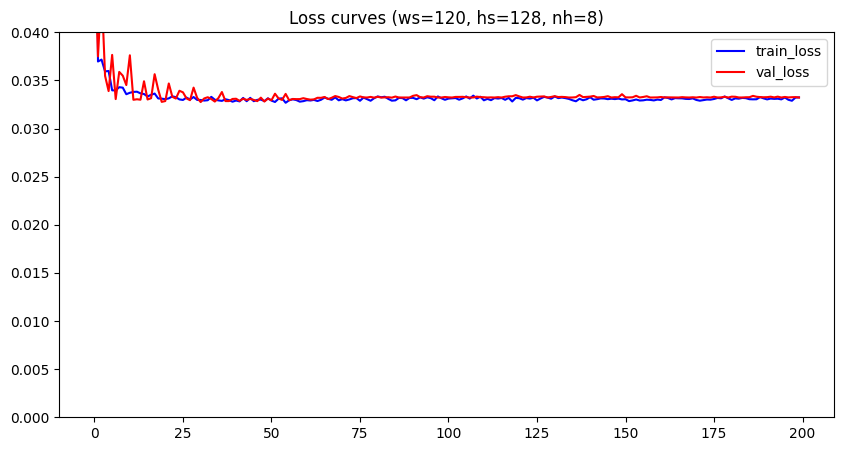

In [78]:
# Define possible values for parameters
window_sizes = [60, 120]
hidden_sizes = [64, 128]
num_heads_list = [4, 8]

# Define other fixed parameters
input_dim = X_train.shape[2]  # 보통 이 값은 feature의 개수
forecast_horizon = 20  # 예시 값, 예측 요구에 맞게 조정
num_epochs = 200
output_dim = 1  # 보통 target 변수의 차원

# Dictionary to store losses for each combination
losses_dict = {}

# Loop over all combinations of parameters
for window_size, hidden_size, num_heads in itertools.product(window_sizes, hidden_sizes, num_heads_list):
    print(f"Training with window_size={window_size}, hidden_size={hidden_size}, num_heads={num_heads}")
    
    # Initialize model, criterion, optimizer, scheduler
    model = InformerModel(input_dim, output_dim, window_size, forecast_horizon, hidden_size=hidden_size, num_heads=num_heads)
    criterion = RMSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=20, verbose=True)

    # Initialize variables to track best results
    best_loss = float('inf')
    best_train_loss = None
    best_model_wts = None
    best_epoch = None

    # Lists to store losses for plotting
    tr_losses_fp = []
    val_losses_fp = []

    # Training loop for 200 epochs
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            
            # Ensure output and y_batch shapes match before loss calculation
            if output.shape[1] != y_batch.shape[1]:
                min_len = min(output.shape[1], y_batch.shape[1])
                output = output[:, :min_len, :]
                if len(y_batch.shape) == 3:
                    y_batch = y_batch[:, :min_len, :]
                elif len(y_batch.shape) == 2:
                    y_batch = y_batch[:, :min_len]

            if len(y_batch.shape) == 2:
                y_batch = y_batch.unsqueeze(-1)
            
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        train_loss /= len(train_loader)
        tr_losses_fp.append(train_loss)  # Save train loss for plotting

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                output = model(x_val)
                
                # Ensure output and y_val shapes match
                if output.shape[1] != y_val.shape[1]:
                    min_len = min(output.shape[1], y_val.shape[1])
                    output = output[:, :min_len, :]
                    if len(y_val.shape) == 3:
                        y_val = y_val[:, :min_len, :]
                    elif len(y_val.shape) == 2:
                        y_val = y_val[:, :min_len]

                if len(y_val.shape) == 2:
                    y_val = y_val.unsqueeze(-1)
                
                loss = criterion(output, y_val)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses_fp.append(val_loss)  # Save validation loss for plotting

        # Save best model and corresponding train loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_train_loss = train_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1  # Record the epoch of the best model

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Best Loss: {best_loss:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Save the best model weights to a file with parameter details
    model_save_path = f'best_model_weights_ws{window_size}_hs{hidden_size}_nh{num_heads}.pth'
    torch.save(best_model_wts, model_save_path)

    # Save the losses to the dictionary with the parameter combination as the key
    key = f'ws{window_size}_hs{hidden_size}_nh{num_heads}'
    losses_dict[key] = {
        'train_loss': tr_losses_fp,
        'val_loss': val_losses_fp
    }

    # Print best validation loss and corresponding train loss
    print(f"Best validation loss : {best_loss:.4f}, Corresponding train loss: {best_train_loss:.4f}, Achieved at Epoch: {best_epoch}")

    # Plotting the train and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(tr_losses_fp)), tr_losses_fp, color='blue', label='train_loss')
    plt.plot(range(len(val_losses_fp)), val_losses_fp, color='red', label='val_loss')
    plt.title(f'Loss curves (ws={window_size}, hs={hidden_size}, nh={num_heads})')
    plt.ylim([0,0.04])
    plt.legend()
    plt.show()

In [86]:
df = pd.read_csv('loss_60_8_64.csv')
tr_losses_fp = df['train_loss']
val_losses_fp = df['validation_loss']

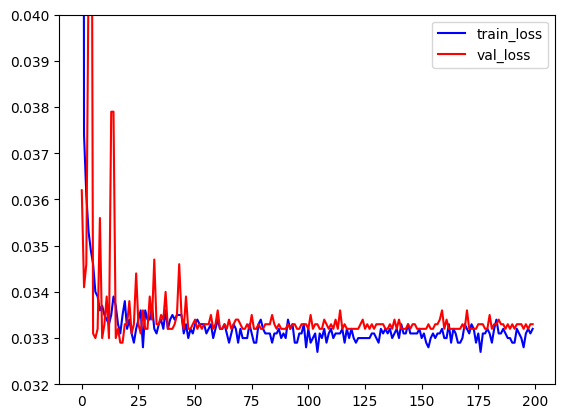

In [89]:
import matplotlib.pyplot as plt
plt.plot(range(len(tr_losses_fp)),tr_losses_fp,color='blue',label='train_loss')
plt.plot(range(len(val_losses_fp)),val_losses_fp,color='red',label='val_loss')
plt.ylim([0.032,0.04])
plt.legend()
plt.show()

In [80]:
# evaluation
model.eval()
with torch.no_grad():
    X_test = torch.tensor(X_test.astype(np.float32), dtype = torch.float32)
    pred = model(X_test)

pred = pred.detach().numpy()
print(pred)

[[[-0.00089352]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]
  [-0.00088764]]]


In [81]:
if TARGET == "diff_close" :
    endPrice = data['종가'].iloc[-1]
    pred_close = []

    for i in pred[0] :
        endPrice = endPrice + endPrice*i
        pred_close.append(endPrice)

    pred = np.array(pred_close).reshape(1, PRED_SIZE)
    pred
else :
    pass

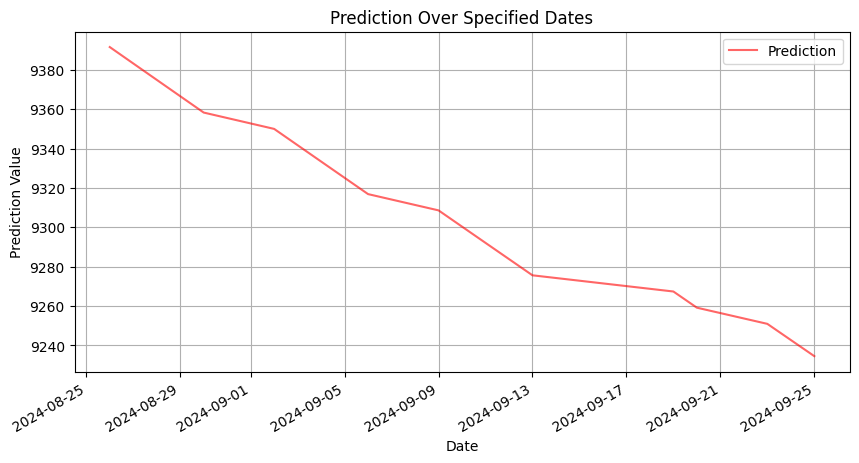

In [82]:
dates = ["2024-08-26", "2024-08-27", "2024-08-28", "2024-08-29", "2024-08-30",
         "2024-09-02", "2024-09-03", "2024-09-04", "2024-09-05", "2024-09-06",
         "2024-09-09", "2024-09-10", "2024-09-11", "2024-09-12", "2024-09-13",
         "2024-09-19", "2024-09-20", "2024-09-23", "2024-09-24", "2024-09-25"]

# Convert dates to pandas datetime for better handling in plotting
date_indices = pd.to_datetime(dates)
pred = np.array(pred).reshape(PRED_SIZE)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(date_indices, pred, color='red', alpha=0.6, label='Prediction')
plt.legend()
plt.gcf().autofmt_xdate()  # Auto-format the dates for better readability
plt.title("Prediction Over Specified Dates")
plt.xlabel("Date")
plt.ylabel("Prediction Value")
plt.grid(True)
plt.show()

In [83]:
pd.DataFrame(pred, columns = ['Predicted_Close'])

,Predicted_Close
0,9391.600586
1,9383.264648
2,9374.935547
3,9366.614258
4,9358.299805
5,9349.993164
6,9341.693359
7,9333.401367
8,9325.117188
9,9316.839844
